In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import libraries
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

In [0]:
data_path = "./drive/My Drive/ML/hw3/data/" # colab path

In [0]:
# accuracy - how correct prediction is!
def evaluate(true, pred):
  return np.mean(true == pred)

In [0]:
def get_data(folder, name):
    y = pd.read_csv(folder + name + "_Labels.csv", index_col = 'Id')
    x = pd.DataFrame(pd.read_pickle(folder + name + "_Features.pkl")).T
    print('loaded', x.shape, y.shape)
    return x,y

In [0]:
# shuffles both x and y together using permutation
def shuffle_data(x, y):
    permutation = np.random.permutation(len(x))
    return x[permutation], y[permutation]

In [0]:
def pre_process_data(x,y):
 
  x['one'] = int(1) # bias
  y = y.reindex(x.index) # reordering labels according to x index
  
  x  = np.array(x)
  y = np.array(y).astype(np.uint8)
  
  x = x / np.linalg.norm(x, axis=0) # l2 normalization
  x = (x - np.mean(x, axis=-1)[..., np.newaxis]) / np.std(x, axis=-1)[..., np.newaxis]
  return x,y

In [0]:
# returns update for the weights
def get_update(weights, x, y, category):
  
  indicator = np.zeros(y.shape)
  indicator[y == category] = 1
  
  temp = (indicator - sigmoid(x @ weights))
  update = np.mean(x.T @ temp, axis=1)
  
#   cost = - np.mean(indicator * (x @ weights) - np.log(1 + np.exp(x @ weights)))
  
  return update

In [0]:
# sigmoid function
def sigmoid(z):
  hx = 1 / (1 + np.exp(-z.astype(np.float64)))
  return hx # sigmoid

In [0]:
def ltheta(weights, x, y):
  pred = predict(x, weights).astype(np.float)[..., np.newaxis]
  true = y
  return np.mean(true != pred)

In [0]:
def predict(x, weights):

  pred_prob = np.concatenate([np.exp(x @ weight)  for weight in weights.values()], axis=-1)

  sum_exp = 1 + np.sum(pred_prob, axis=-1)
  pred_prob = pred_prob / sum_exp[..., np.newaxis]
  
  pred_prob = np.concatenate([pred_prob, 1 - np.sum(np.array(pred_prob), axis=1)[..., np.newaxis]], axis=-1)
  
  pred_y = np.argmax(np.array(pred_prob), axis=1) + 1
  
  return pred_y

In [0]:
def train(x, y, val_x1, val_y1, epochs, n0, n1, batch_n, stop_criteria):
  
  train_Ltheta, val_Ltheta, train_acc_list, val_acc_list = [], [], [], []
  epochs_done = 0
  flag = 0
  categories = np.unique(y)
  print("categories in training data", categories)
  
  weights = {}
  for category in categories[:-1]:
    weights[category] = np.random.rand(x.shape[1], 1) #initiating weights randomly from [0,1) per category
    
  for epoch in range(epochs):
    
    step_size = n0 / (n1 + epoch) # decreases step size according to epoch count
    
#     x, y = shuffle_data(x, y) # shuffle

    batchList_x, batchList_y = np.array_split(x, batch_n), np.array_split(y, batch_n)

    for batch_x, batch_y in zip(batchList_x, batchList_y): # batch wise upadating gradients as asked in question

      for category in categories[:-1]: # training classfiers except last one
        update = get_update(weights[category], x, y, category)

        weights[category] += step_size * update[:, np.newaxis] # gradient descent
        

    train_Ltheta.append(ltheta(weights, x, y))
    val_Ltheta.append(ltheta(weights, val_x1, val_y1))
    train_acc_list.append(evaluate(y, predict(x, weights)))
    val_acc_list.append(evaluate(val_y1, predict(val_x1, weights)))
    
    epochs_done += 1
    print('Epoch', epochs_done, "Train_L", train_Ltheta[-1], "Val_L", val_Ltheta[-1])
    if(epoch > 2):
      if val_Ltheta[-1] > (1 - stop_criteria) * val_Ltheta[-2]:
        flag += 1
        if(flag > 5):
          break
#       else:
#         flag = 0
        
  return weights, epochs_done, train_Ltheta, val_Ltheta, train_acc_list, val_acc_list

**Load and pre process data**

In [13]:
# load train data

train_x, train_y = get_data(data_path, 'Train')

loaded (4000, 512) (4000, 1)


In [14]:
# load validation data

val_x, val_y = get_data(data_path, 'Val')

loaded (2000, 512) (2000, 1)


In [15]:
# load test data

test_x = pd.DataFrame(pd.read_pickle(data_path + "Test" + "_Features.pkl")).T
print('loaded', test_x.shape)

loaded (2000, 512)


In [0]:
train_x_c, train_y_c = train_x.copy(), train_y.copy()
train_x_c,train_y_c = pre_process_data(train_x_c,train_y_c)

val_x_c, val_y_c = val_x.copy(), val_y.copy()
val_x_c, val_y_c = pre_process_data(val_x_c, val_y_c)

**1. Run your implementation on the provided training data with max epoch = 1000;m = 16; step size 0 = 0.1; step size 1 = 1; stopping criteria = 0:00001.**

In [18]:
epochs = 1000
n0,n1 = 0.1,1
batch_size = 16
stop_criteria = 0.00001

batch_n = int(len(train_x_c) / batch_size)
weights, epochs_done, train_Ltheta, val_Ltheta, train_acc_list, val_acc_list = train(train_x_c,train_y_c, val_x_c, val_y_c, epochs, n0, n1, batch_n, stop_criteria)

categories in training data [1 2 3 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1 Train_L 0.69675 Val_L 0.715
Epoch 2 Train_L 0.64275 Val_L 0.708
Epoch 3 Train_L 0.42675 Val_L 0.583
Epoch 4 Train_L 0.4305 Val_L 0.5925
Epoch 5 Train_L 0.43225 Val_L 0.598
Epoch 6 Train_L 0.3815 Val_L 0.571
Epoch 7 Train_L 0.41675 Val_L 0.598
Epoch 8 Train_L 0.3655 Val_L 0.5735
Epoch 9 Train_L 0.38075 Val_L 0.57
Epoch 10 Train_L 0.402 Val_L 0.599
Epoch 11 Train_L 0.36525 Val_L 0.5735
Epoch 12 Train_L 0.3975 Val_L 0.5995
Epoch 13 Train_L 0.358 Val_L 0.5795
Epoch 14 Train_L 0.3745 Val_L 0.591


**(a) Report the number of epochs that your algorithm takes before exiting.**

In [19]:
epochs_done

14

14

**(b) Plot the curve showing L(theta) as a function of epoch.**

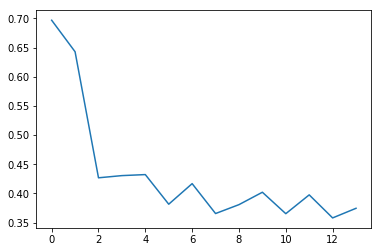

In [20]:
plt.plot(range(epochs_done), train_Ltheta)
plt.show()

**(c) What is the final value of L(theta) after the optimization?**

In [21]:
train_Ltheta[-1]

0.3745

0.3745

**2. Keep m = 16; stopping criteria = 0:00001, experiment with different values of step size 0 and step size 1. Can you find a
pair of parameters (step size 0; step size 1) that leads to faster convergence?**

In [22]:
epochs = 1000
n0,n1 = 0.001,0.1
batch_size = 8
stop_criteria = 0.000001

batch_n = int(len(train_x_c) / batch_size)

weights, epochs_done, train_Ltheta, val_Ltheta, train_acc_list, val_acc_list = train(train_x_c, train_y_c, val_x_c, val_y_c, epochs, n0, n1, batch_n, stop_criteria)

categories in training data [1 2 3 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1 Train_L 0.57075 Val_L 0.6325
Epoch 2 Train_L 0.40825 Val_L 0.574
Epoch 3 Train_L 0.39775 Val_L 0.5805
Epoch 4 Train_L 0.39325 Val_L 0.5785
Epoch 5 Train_L 0.39075 Val_L 0.5825
Epoch 6 Train_L 0.3925 Val_L 0.5845
Epoch 7 Train_L 0.39125 Val_L 0.583
Epoch 8 Train_L 0.39075 Val_L 0.58
Epoch 9 Train_L 0.39025 Val_L 0.5785
Epoch 10 Train_L 0.38775 Val_L 0.577
Epoch 11 Train_L 0.38625 Val_L 0.577
Epoch 12 Train_L 0.3855 Val_L 0.576
Epoch 13 Train_L 0.385 Val_L 0.575
Epoch 14 Train_L 0.384 Val_L 0.575
Epoch 15 Train_L 0.384 Val_L 0.573
Epoch 16 Train_L 0.38275 Val_L 0.5765
Epoch 17 Train_L 0.38325 Val_L 0.5785


**(a) Report the values of (step size 0; step size 1). How many epochs does it take? What is the final value of L(theta)?**

In [23]:
print("n0:", n0)
print("n1:", n1)
print("It took", epochs_done, "epochs")
print("final value of L(theta)", train_Ltheta[-1])

n0: 0.001
n1: 0.1
It took 17 epochs
final value of L(theta) 0.38325


```
n0: 0.001
n1: 0.1
It took 17 epochs
final value of L(theta) 0.38325
```



**(b) Plot the curve showing L(theta) as a function of epoch.**

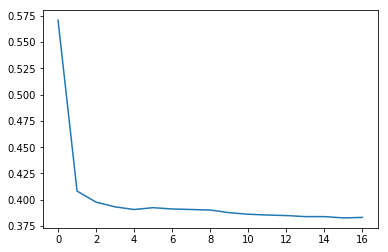

In [24]:
plt.plot(range(epochs_done), train_Ltheta)
plt.show()

**3. Evaluate the performance on validation data**

In [25]:
# prediction

pred_y = predict(val_x_c, weights)

print("Unique", np.unique(pred_y), np.unique(val_y_c))                

print("Score", evaluate(val_y_c,pred_y.astype(np.float)))

Unique [1 2 3 4] [1 2 3 4]
Score 0.271393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


**(a) Plot L(theta) as a function of epoch. On the same plot, show two curves, one for training and one
for validation data.**

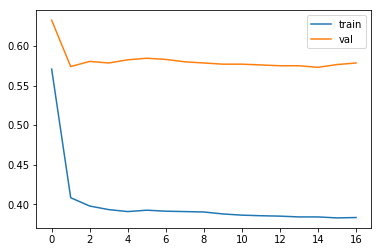

In [26]:
plt.plot(range(epochs_done), train_Ltheta, label="train")
plt.plot(range(epochs_done), val_Ltheta, label="val")
plt.legend()
plt.show()

**(b) Plot the accuracy as a function of epoch. On the same plot, show two curves, one for training
and one for validation data.**

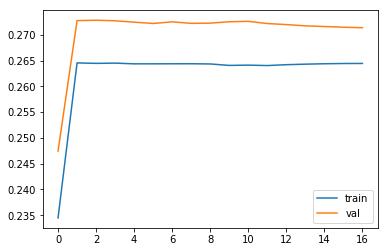

In [27]:
plt.plot(range(epochs_done), train_acc_list, label="train")
plt.plot(range(epochs_done), val_acc_list, label="val")
plt.legend()
plt.show()

**4. Report the confusion matrices on the validation and the training data.**

In [28]:
def generate_conf_matrix(y, pred_y):
  conf_matrix = np.zeros((len(np.unique(y)),len(np.unique(pred_y))))

  for true, pred in zip(y, pred_y):
    conf_matrix[true[0]-1][pred-1] += 1
    
  return conf_matrix

train_true = train_y_c.copy().astype(np.int)
train_pred = predict(train_x_c, weights)
val_true = val_y_c.copy().astype(np.int)
val_pred = predict(val_x_c, weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Confusion Matrix for training data

In [29]:
generate_conf_matrix(train_true, train_pred)

array([[494., 128.,  34., 127.],
       [119., 714., 135., 301.],
       [ 30., 143., 361., 282.],
       [ 22.,  77., 135., 898.]])

Confusion Matrix for validation data

In [30]:
generate_conf_matrix(val_true, val_pred)

array([[146.,  75.,  20.,  75.],
       [126., 272.,  88., 174.],
       [ 37., 157.,  70., 174.],
       [ 27., 106.,  98., 355.]])

**2.4 Submit the result in Kaggle**

0.38333